In [1]:
pip install geopandas rasterstats pygeos

     |████████████████████████████████| 1.0 MB 4.9 MB/s 
     |████████████████████████████████| 2.1 MB 44.8 MB/s 
     |████████████████████████████████| 6.3 MB 36.8 MB/s 
     |████████████████████████████████| 16.7 MB 43.1 MB/s 
     |████████████████████████████████| 19.3 MB 410 kB/s 
     |████████████████████████████████| 130 kB 45.6 MB/s 


In [1]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
import os

In [2]:
base_dir= os.getcwd()
directory = "/Images"
imag_dir = base_dir + directory
try:
    os.mkdir(imag_dir)
except:
    print("already image directory")
directory = "/Data"
data_dir = base_dir + directory
try:
    os.mkdir(data_dir)
except:
    print("already data directory")
directory = "/Reproject_Data"
path = base_dir+directory
try:
 os.mkdir(path)
except:
  print("already reproject directory")
projected_dir = base_dir + '/Reproject_Data'
directory = "/poa"
path = base_dir+directory
try:
 os.mkdir(path)
except:
  print("already poa directory")
suitability_data = base_dir + '/poa'
directory = "/temp_files"
path = base_dir+directory
try:
 os.mkdir(path)
except:
  print("already poa directory")
temp_data = base_dir + '/temp_files/'

already image directory
already data directory
already reproject directory
already poa directory
already poa directory


In [3]:
def download_and_unzip(url, extract_to=data_dir):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)

In [6]:
url_dem = "https://github.com/deependran7/Solar-and-Wind-Potential-Assessment-Nepal/blob/main/Digital_Elevation_Model_Nepal.zip?raw=true"
url_shape_files = "https://github.com/deependran7/Solar-and-Wind-Potential-Assessment-Nepal/blob/main/ShapeFileData.zip?raw=true"
url_solar_data = "https://github.com/deependran7/Solar-and-Wind-Potential-Assessment-Nepal/blob/main/SolarData.zip?raw=true"
url_wind_data = "https://github.com/deependran7/Solar-and-Wind-Potential-Assessment-Nepal/blob/main/WindData.zip?raw=true"
url_land_cover_sentinel = "https://github.com/deependran7/Solar-and-Wind-Potential-Assessment-Nepal/blob/main/land_cover_sentinel.zip?raw=true"
url_reproject_py = "https://github.com/deependran7/Solar-and-Wind-Potential-Assessment-Nepal/blob/main/reproject.zip?raw=true"

In [8]:
download_and_unzip(url_shape_files,extract_to = data_dir)
download_and_unzip(url_dem, extract_to = data_dir)
download_and_unzip(url_solar_data,extract_to = data_dir)
download_and_unzip(url_wind_data, extract_to = data_dir)
download_and_unzip(url_land_cover_sentinel, extract_to = data_dir)
download_and_unzip(url_reproject_py, extract_to = '.')

In [4]:
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import shapely
import rasterio
from rasterio.warp import reproject, Resampling
from rasterstats import zonal_stats
from shapely.ops import nearest_points
import matplotlib.pyplot as plt

from pyproj.crs import CRS
import numpy as np
from reproject import reproject_data
from raster_calculation import Calc
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal,ogr,osr,gdal_array

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [5]:
#our projection System transverse mercator
projection_dict = {'proj': 'tmerc',
 'lat_0': 0,
 'lon_0': 84,
 'k': 0.9996,
 'x_0': 500000,
 'y_0': 0,
 'datum': 'WGS84',
 'units': 'm',
 'no_defs': None,
 'type': 'crs'}

In [6]:
boundary = gpd.read_file(data_dir + '/Boudary Files/Provincial.shp')
boundary = boundary.to_crs(CRS.from_dict(projection_dict))
#for calculaiton of distances
substation = gpd.read_file(data_dir + '/Substation/Substation_final_data.shp')
roads = gpd.read_file(data_dir + '/nepal_roads_gtsk_43/gstk_nepal_43_roads.shp')
protected = gpd.read_file(data_dir + '/Road and Protected/protected areas.shp')
protected = protected.to_crs(CRS.from_dict(projection_dict))
buffered_water_bodies = gpd.read_file(data_dir+ '/Water_Bodies/Buffered/water_100m.shp')
buffer_water = buffered_water_bodies.to_crs(CRS.from_dict(projection_dict))
##raster stats
ghi = data_dir + '/Solar_and_Temperature/DailySumGHI.tif'
w_density = data_dir + '/Wind Data/NPL_power-density_50m.tif' 
w_speed = data_dir + '/Wind Data/NPL_wind-speed_50m.tif' 
elevation = data_dir + '/Digital_Elevation_Model_Nepal.tif'
aspect = data_dir +  '/DEM 90m Nepal/Aspect_data.tif'

template = data_dir + '/template.tif'
land_cover_senti = data_dir + '/land_cover.tif'
feasible_land = data_dir + '/land_cover/grass_shrub_barren.tif'
slope = data_dir + '/DEM 90m Nepal/DEM Nepal/Nepal_Slope.tif'

In [13]:
re_land_cover_data =reproject_data(land_cover_senti,projected_dir + "/land_cover_sent.tif", template)
re_ghi_data =reproject_data(ghi,projected_dir + "/ghi.tif", template)
re_elevation_data =reproject_data(elevation,projected_dir + "/elevation.tif", template)

PROJCS["WGS_1984_Transverse_Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",84],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
PROJCS["WGS_1984_Transverse_Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",84],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETE

In [14]:
slope_data = data_dir+  "/nepal_slope.tif"
aspect_data = data_dir+  "/nepal_aspect.tif"

In [15]:
def calculate_slope_aspect(DEM,slope_path,aspect_path):
    gdal.DEMProcessing(slope_path, DEM, 'slope')
    gdal.DEMProcessing(aspect_path, DEM, 'aspect')
    
calculate_slope_aspect(elevation, slope_data,aspect_data)

In [16]:
re_slope_data =reproject_data(slope_data,projected_dir + "/slope.tif", template)
re_aspect_data =reproject_data(aspect_data,projected_dir + "/aspect.tif", template)

PROJCS["WGS_1984_Transverse_Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",84],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
PROJCS["WGS_1984_Transverse_Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",84],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETE

In [17]:
#reclassification
built_up_data = data_dir + '/built_up_data.tif'

with rasterio.open(re_land_cover_data) as src:    
    # Read as numpy array
    array = src.read().astype('int16')
    profile = src.profile
    # Reclassify
    array[np.where(array == 1) ] = 0
    array[np.where(array == 2) ] = 0
    array[np.where(array == 3) ] = 0
    array[np.where(array == 4) ] = 0
    array[np.where(array == 5) ] = 0
    array[np.where(array == 6) ] = 0
    array[np.where(array == 7) ] = 1
    array[np.where(array == 8)] = 0
    array[np.where(array == 9)] = 0
    array[np.where(array == 10)] = 0
  
with rasterio.open(built_up_data, 'w', **profile) as dst:
    # Write to disk
    dst.write(array)
    del array

In [24]:
#reclassification
feasible_area_data = data_dir + '/feasible_area_data.tif'

with rasterio.open(re_land_cover_data) as src:    
    # Read as numpy array
    array = src.read().astype('int16')
    profile = src.profile

    # Reclassify
    array[np.where(array == 1) ] = 0
    array[np.where(array == 2) ] = 0
    array[np.where(array == 3) ] = 1
    array[np.where(array == 4) ] = 0
    array[np.where(array == 5) ] = 0
    array[np.where(array == 6) ] = 0
    array[np.where(array == 7) ] = 0
    array[np.where(array == 8) ] = 1
    array[np.where(array == 9) ] = 0
    array[np.where(array == 10) ] = 0
    
with rasterio.open(feasible_area_data, 'w', **profile) as dst:
    # Write to disk
    dst.write(array)
    del array

In [25]:
#reprojecting the new data
re_feasible_data = reproject_data(feasible_area_data,projected_dir + "/feasible.tif", template)
re_built_up_data = reproject_data(built_up_data,projected_dir + "/built_up.tif", template)

PROJCS["WGS_1984_Transverse_Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",84],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [20]:
#raster calculation
#raster calculation
#ghi>4.1, feasible area, slope<23, elevation<4000, 112.5<aspect<247.5 

In [26]:
output_file = suitability_data +'/solar_feasible_poa.tif'
Calc("(A < 4000)*(B)*(C > 4.1)*(D > 112.5)*(D < 247.5)*(E < 24)", A=re_elevation_data, B=re_feasible_data,C=re_ghi_data, D = re_aspect_data, E = re_slope_data, outfile=output_file)

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 

In [27]:
solar_poa_r = suitability_data + '/solar_poa_r.tif'
with rasterio.open(output_file) as src:    
    # Read as numpy array
    array = src.read().astype('int16')
    count = np.count_nonzero(array == 1)
    print(count*30*30/1000000)
    profile = src.profile
    
with rasterio.open(solar_poa_r, 'w', **profile) as dst:
    # Write to disk
    dst.write(array)
    del array

520.4511


In [28]:
re_solar_poa_data =reproject_data(solar_poa_r,projected_dir + "/solar_poa.tif", template)

PROJCS["WGS_1984_Transverse_Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",84],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [7]:
from rasterio.mask import mask
from rasterio.plot import show

In [8]:
def Clip_Raster_With_Features(input_raster,output_clip_name_list,input_shape_file):
    for i,clip_name in enumerate(output_clip_name_list):
        
        src  = rasterio.open(input_raster)
        def getFeatures(gdf):
            """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
            import json
            return [json.loads(gdf.to_json())['features'][i]['geometry']]
        coords = getFeatures(input_shape_file)
        clipped_array, clipped_transform = mask(dataset=src, shapes=coords, crop=True)

        input_shape_file= input_shape_file.to_crs(src.crs)
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                         "height": clipped_array.shape[1],
                         "width": clipped_array.shape[2],
                         "transform": clipped_transform})
        out_tif= temp_data+clip_name
        with rasterio.open(out_tif, "w", **out_meta) as dest:
            dest.write(clipped_array)

In [8]:
output_name = ['prove1.tif', 'prove2.tif','prove3.tif', 'prove4.tif','prove5.tif','prove6.tif','prove7.tif']
Clip_Raster_With_Features(re_solar_poa_data, output_name ,boundary)

In [9]:
def open_raster(input_raster, band_number = 1):
  raster = gdal.Open(input_raster)
  raster_band = raster.GetRasterBand(band_number)
  return raster, raster_band

def raster_to_vector(input_raster,band_number, shape_file_dir):
  raster, raster_band = open_raster(input_raster, band_number=band_number)
  shp_driver = ogr.GetDriverByName("ESRI Shapefile")
  new_shp = shp_driver.CreateDataSource(shape_file_dir)
  new_shp.CreateLayer('raster_data',geom_type=ogr.wkbMultiPolygon)
  dst_layer = new_shp.GetLayer()
  newfield = ogr.FieldDefn("values", ogr.OFTReal)
  dst_layer.ResetReading()
  dst_layer.CreateField(newfield)
  gdal.Polygonize(raster_band, None, dst_layer, 0, [], callback=None)

In [33]:
for prov_c, prov_tif in enumerate(output_name):
    solar_poa_data = temp_data + prov_tif
    shape_file_dir = temp_data + 'prove'+ str(prov_c +1) +'_poa.shp'
    raster_to_vector(solar_poa_data,1,shape_file_dir)

In [34]:
solar_poa = gpd.GeoDataFrame()
for i in range(len(output_name)):
  prov_shp = gpd.read_file(temp_data + 'prove'+ str(i+1) + "_poa.shp")
  prov_shp = prov_shp.set_crs(CRS.from_dict(projection_dict))
  solar_poa = solar_poa.append(prov_shp)

In [39]:
solar_poa =solar_poa.set_crs(CRS.from_dict(projection_dict))
poa = solar_poa.query('values==1')
poa.to_file(suitability_data + '/solar_final_poa.shp')

In [40]:
#water bodies exlcusion
poa = gpd.overlay(poa, buffer_water, how='difference', make_valid=True, keep_geom_type=True)
poa['Area'] = poa.area/1000000
poa = poa.query('Area>=0.01')

In [21]:
def dict_arr(stat):
    arr =[]
    for i in range(len(stat)):
        value = stat[i]['mean']
        arr.append(value)
    return arr

In [42]:
def min_distance(poa,place):
    pbar = tqdm(total=len(poa))
    print("forming Unary_union")
    place= place.to_crs(poa.crs).unary_union
    print("Unary Formation complete")
    distance =[]
    for p in poa.geometry:
        nearest_geoms = nearest_points(p, place)
        min_dist = nearest_geoms[0].distance(nearest_geoms[1])
        distance.append(min_dist)
        pbar.update(1)
    pbar.close()
    return distance 

In [43]:
#Finding nearst Distance
poa['d_sub'] = min_distance(poa,substation)
poa['d_roads'] = min_distance(poa,roads)

 12%|█▏        | 931/7654 [00:00<00:01, 4891.85it/s]

forming Unary_union
Unary Formation complete


  0%|          | 0/7654 [00:00<?, ?it/s]

forming Unary_union


  1%|          | 42/7654 [00:00<01:16, 99.89it/s]

Unary Formation complete


100%|██████████| 7654/7654 [00:17<00:00, 431.09it/s]


In [44]:
poa['elevation'] = dict_arr(zonal_stats(poa.geometry,re_elevation_data,stats="mean",all_touched = True))
poa['avg_ghi'] = dict_arr(zonal_stats(poa.geometry,re_ghi_data,stats="mean",all_touched = True))

In [45]:
l_e = 30
d_f = 1
#from solar model
poa['cf'] =poa['avg_ghi']*0.0449187 +(-0.0745561)
poa['incap'] = poa.Area*l_e*d_f #mw

#calculation of LCOE
hours = 8760
tdm =1.3
i=0.1
n=25
I_c =1210000 #per mw
O_gc = 10000#per mw
T_c = 450#mw/km
d_s = poa["d_sub"] * tdm/1000
S_c = 70000#/mw
R_c = 60000#/km
d_r =poa['d_roads']/1000
cf = poa['cf']
i_d = (i*(1+i)**n)/(((1+i)**n)-1)

In [46]:
def calc_cost():
    lt_gen = []
    lt_tra = []
    for i in range(len(poa)):
        gen_cost = (I_c*i_d + O_gc )/(cf.values[i]*hours)
        lt_gen.append(gen_cost)

    for i in range(len(poa)):
        l_road = ((R_c*d_r.values[i])*i_d)/(cf.values[i]*70*hours)
        l_sub = ((T_c*d_s.values[i] + S_c)*i_d)/(cf.values[i]*hours)
        lt = l_road+l_sub
        lt_tra.append(lt)
    return [lt_gen,lt_tra]
a = calc_cost()

In [47]:
poa['lt_gen'] = a[0]
poa['lt_tra'] = a[1]
poa['lt_tot'] = poa['lt_gen']+poa['lt_tra']

In [48]:
egen = []
for i in range(len(poa)):
    a = 30*poa.Area.values[i]*cf.values[i]*8760
    egen.append(a)
poa['egen'] = egen

In [49]:
data = poa.query('Area>=0.0009')
data.to_file(suitability_data +'/solar_poa_water_excluded.shp')

In [6]:
data = gpd.read_file(suitability_data +'/solar_poa_water_excluded.shp')

<h3>Finding Provincial Capacity</h3>

In [27]:
#provincial potential estimation
def find_capacity(poa, boundary):
    install_potential = []
    generation = []
    prov_name = []
    area = []
    data = pd.DataFrame()
    boundary = boundary.to_crs(poa.crs)
    for name in boundary.Name:
        Province =  boundary[boundary["Name"] == name].geometry
        poly_gdf = gpd.GeoDataFrame(geometry=Province, crs=boundary.crs)
        proclip = gpd.overlay(poa, poly_gdf, how='intersection', make_valid=True, keep_geom_type=True)
        install_potential.append(proclip.incap.sum())
        area.append(proclip.area.sum())
        generation.append(proclip.egen.sum())
        prov_name.append(name)
        print('Calculation of' + name + 'is Complete')
        
    data['Name'] = prov_name
    data['Area'] = area
    data['Capacity'] = install_potential
    data['Generation'] = generation
    return data

In [52]:
prov_data = find_capacity(data,boundary)
prov_data.to_csv('solar_potential.csv')

Calculation ofProvince 1is Complete
Calculation ofProvince 2is Complete
Calculation ofBagmati Provinceis Complete
Calculation ofGandaki Provinceis Complete
Calculation ofProvince 5is Complete
Calculation ofKarnali Provinceis Complete
Calculation ofSudurpashim Provinceis Complete


In [55]:
import matplotlib
plt.rcParams.update({'font.size': 15})

In [29]:
#%%finding moving average
def calc_mov_avg(numbers,size):
    window_size = size
    i = 0
    moving_averages = []
    while i < len(numbers) - window_size + 1:
        this_window = numbers[i : i + window_size]
        window_average = sum(this_window) / window_size
        moving_averages.append(window_average)
        i += 1
    return moving_averages

In [57]:
sd_sort = data.sort_values('lt_tot')
egen = pd.DataFrame(sd_sort, columns = ['egen'])
sd_sort['cum_egen_TWh'] = egen.cumsum()/1000000

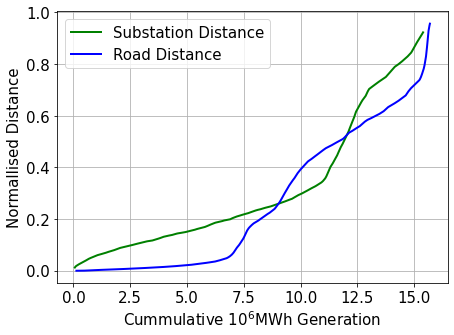

In [58]:
#Distance Analysis
#%% Distance Analysis
d_sort = data.sort_values('d_sub')
egen = pd.DataFrame(d_sort, columns = ['egen'])
d_sort['cum_egen_sub'] = egen.cumsum()/1000000
s_power_sub = pd.DataFrame(d_sort, columns =['cum_egen_sub']).round(decimals=2).to_numpy()
d_sub = pd.DataFrame(d_sort, columns = ['d_sub']).to_numpy()
d_sort= data.sort_values('d_roads')
egen = pd.DataFrame(d_sort, columns = ['egen'])
d_sort['cum_egen_road'] = egen.cumsum()/1000000
s_power_road = pd.DataFrame(d_sort, columns =['cum_egen_road']).round(decimals=2).to_numpy()
d_road = pd.DataFrame(d_sort, columns = ['d_roads']).to_numpy()

fig,ax= plt.subplots(1,1 ,figsize=(7,5))
plt.plot(calc_mov_avg(s_power_sub,100),calc_mov_avg(d_sub/max(d_sub),100), 'g',lw=2)
plt.plot(calc_mov_avg(s_power_road,100),calc_mov_avg(d_road/max(d_road),100), 'b', lw=2)
plt.legend(['Substation Distance','Road Distance'])
plt.grid()
#plt.ylim((50, 210)) 
plt.xlabel('Cummulative $10^6$MWh Generation')
plt.ylabel('Normallised Distance')
plt.savefig('Images/solar_distance.png')
plt.show()

In [59]:
sd  = data
df = sd.query("cf >0.15")
sd_sort = df.sort_values('lt_tot')
egen = pd.DataFrame(sd_sort, columns = ['egen'])
sd_sort['cum_egen_TWh'] = egen.cumsum()/1000000

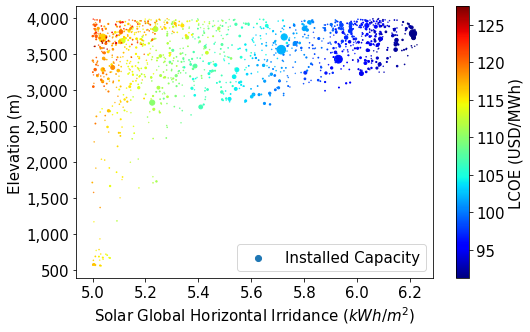

In [60]:
fig,ax = plt.subplots(1,1 ,figsize=(8,5))
CS = plt.scatter( x = sd_sort['avg_ghi'], y = sd_sort['elevation'], s = sd_sort['incap']/2,label = 'Installed Capacity', 
            c = sd_sort['lt_tot'], cmap = plt.get_cmap('jet'))

plt.xlabel('Solar Global Horizontal Irridance ($kWh/m^2$)')
ax.legend()
plt.ylabel('Elevation (m)')
fig.colorbar(CS, label="LCOE (USD/MWh)")
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig('Images/final_solar_analysis.png')
plt.show()